In [12]:
# Relevant Libraries
import sys
sys.path.append("./../..")

from IPython.utils import io
import sys
from numba import jit
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from numpy import mean, array, abs

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE
from sbi.utils.user_input_checks import process_prior
import torch

# WHAT TO DO

## The Model
- Improve the initial description of the model.
- Improve readability of the simulator, with possible validation
- Improve description of bare `x` traces
- Improve theoretical observable validation ($\chi^2$, statistical tests, etc.)
    - How does the model behave with respect to the number of traces?
- Add entropy description !!!

## THE SBI
- Improve the description of the SBI algorithm
- SBI with bare `x` traces: results and discussion. Be *detailed*.
- SBI with only autocorrelation trace: results and discussion. Be *detailed*.
- SBI with only autocorrelation fit: results and discussion. Be *detailed*.
- SBI with only cumulative mean: results and discussion. Be *detailed*.
- For every SBI trial, we need to have a comprehensive way to test the quality of the fit. HOW? Try a lot and see the dispersion? The error? Which error? How does the stocastichity affect the result and the error?
- SBI with best trial and multi-round inference: results and discussion. Be *detailed*. Try a lot of times.


# The Run&Tumble Model

## Description

A particle undergoing RnT motion moves in a sequence of runs at constant self-propulsion speed $\omega$ interrupted by sudden changes (tumbles) in its orientation that happen at Poissonian rate $\alpha$. In this case we will examine the one-dimensional case.

The simulator runs the RnT model for a given number of particles and time steps. The particles are initialized all at $x_0 = 0$ and right facing velocity.
The particles move in 1D space with an harmonic potential $V(x) = \frac{1}{2} k x^2$ acting on them. There are no boundary conditions.

Every second the particles change their velocity to the opposite direction with probability $\alpha$.

The simulation is done in the following way:
1. Initialize the particles at $x_0 = 0$ and right facing velocity.
2. Check if a tumble event happens at the current time step.
2. Update the position of the particles according to the current velocity, potential and add a stochastic term.

The equation of motion is:
$$
\dot{x} = -\partial_x V(x) \pm \omega + \nu(t)
$$

The actual implementation of the simulator is done in the following way:

$$
x_{t+1} = x_t + (-k x_t \pm \omega) dt + \nu\sqrt{2Ddt}
$$
Where $\nu$ is a random number drawn from a normal distribution with mean 0 and standard deviation 1.

In [15]:
# The Simulator
@jit
def RunTumble(param, n_sim,dt=0.01, TotalT=1, keep_f = False):
    k = param[0]
    omega = param[1]
    alpha = param[2]
    D = omega*omega / alpha
    
    total_time_steps = np.int64(TotalT / dt)
    
    x = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, total_time_steps))
    
    direction = np.ones((1, n_sim))
    f_trace = np.zeros((n_sim, total_time_steps))
    
    for n in range(1, total_time_steps):
        change = np.random.uniform(0, 1, size=(1, n_sim)) < alpha * dt / 2 # Change direction with probability alpha*dt/2
        change = -(change *2 -1) # From boolean to -1 or 1 (false = 1, true = -1)
        direction = change*direction # Change direction if change is true
        nu = np.random.normal(0, 1, size=(1, n_sim))
        x[:] = x[:] + (-k * x[:] + omega * direction) * dt + np.sqrt(2 * D * dt) * nu
        x_trace[:, n] = x[:,]
        if keep_f:
            f_trace[:, n] = ((-k * x[:] + omega * direction) * dt + np.sqrt(2 * D * dt) * nu)[:,]

    return x_trace, f_trace

Let us define the parameters of our model and simulation. As this is a highly stochastic model, we will run the simulation for a large number of particles.

In [14]:
ModelParameter = np.array([1, 1, 0.5]) # [k, omega, alpha]
NumberOfParticles = 1000 # Number of particles to simulate
TotalTime = 2 # Total time of simulation
dt = 1e-3 # Time step
t = np.arange(0, TotalTime, dt) # Time vector

Let be noted that `ModelParameter` is a matrix of shape `(2, n_particles)` where the first column is the elastic constant $k$ and the second column is the self-propulsion speed $\omega$. We maintain alpha constant.

Let's simulate a single example particle and visualize its trajectory.

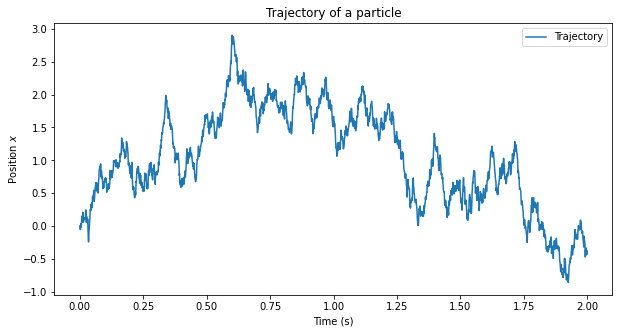

In [7]:
x_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime)[0] # Run the model

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, x_trace[0,:], label="Trajectory")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position $x$")
ax.legend()
ax.set_title("Trajectory of a particle");


We can also see the distribution of the trajectories of the particles.

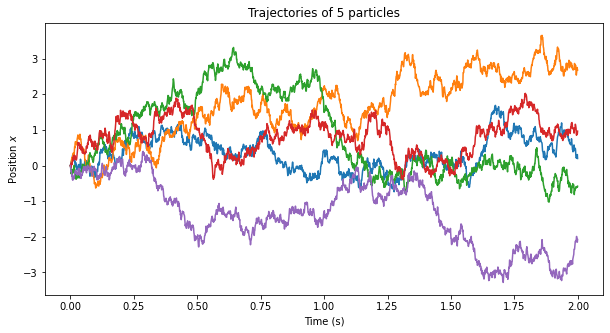

In [8]:
x_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime)[0] # Run the model

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in np.arange(0, 5):
    ax.plot(t, x_trace[i,:], label="Trajectory")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position $x$")
ax.set_title("Trajectories of 5 particles");

## Theoretical Observables


From the paper we can derive the following observables for the RnT model, and check them against our simulations. All averages are taken over the ensemble of particles.

First moment of the position of a RnT particle:

$$\langle x(t) \rangle = x_0 e^{-kt} + \frac{\omega}{k - \alpha} \left(e^{-\alpha t}- e^{-kt}\right)$$

Second moment of the position of a RnT particle:

$$
\begin{aligned}
\left\langle x^2(t)\right\rangle &= x_0^2 e^{-2 k t}+\frac{D}{k}\left(1-e^{-2 k t}\right)+2 \frac{x_0 w}{k-\alpha}\left(e^{-(k+\alpha) t}-e^{-2 k t}\right) \\
& +2 w^2\left(\frac{\exp (-2 k t)}{2 k(k-\alpha)}+\frac{\exp (-(k+\alpha) t)}{(k+\alpha)(\alpha-k)}+\frac{1}{2 k(k+\alpha)}\right)
\end{aligned}
$$

Then, the mean square displacement at stationarity is
$$
\lim _{t \rightarrow \infty} R^2(t)=x_0^2+\frac{D}{k}+\frac{w^2}{k(k+\alpha)}
$$

In [9]:
## Helper Functions
def EmpiricalFirstMoment(data):
    return np.mean(data,axis = 0)

def EmpiricalSecondMoment(data):
    return np.mean(data**2,axis=0)

def TheoricalFirstMoment(k, omega, alpha, t, x0 = 0):
    return x0 * np.exp(-k*t) + (omega / (k - alpha)) * (np.exp(-alpha*t) - np.exp(-k*t))

def TheoricalSecondMoment(k, omega, alpha, t, x0 = 0):
    D = omega**2 / alpha
    return  x0**2 * np.exp(-2*k*t) + D/k * (1 - np.exp(-2*k*t)) + 2*x0*omega/(k-alpha) * (np.exp(-(k+alpha)*t) - np.exp(2*k*t)) + 2*omega**2 *(np.exp(-2*k*t/(2*k*(k-alpha))) + np.exp(-(k+alpha)*t)/((k+alpha)*(alpha-k)) + 1/(2*k*(k+alpha)))

def MeanSquareDisplacement(k, omega, alpha, x0 = 0):
    D = omega**2 / alpha
    return x0**2 + D/k + omega**2/(k*(k+alpha))

Let's define some parameters, for example $k = 1, \omega = 1, \alpha = 0.5$ and run the simulation for a large number of particles to check the observables.

In [10]:
k = 1
omega = 1
alpha = 0.5

ModelParameter = np.array([k, omega, alpha]) # [k, omega, alpha, D]
NumberOfParticles = 10_000 # Number of particles to simulate
TotalTime = 5 # Total time of simulation
dt = 1e-4 # Time step
t = np.arange(0, TotalTime, dt) # Time vector

In [11]:
x_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime)[0] # Run the model

# Compute the empirical first and second moments
EmpiricalFirstMoment_ = EmpiricalFirstMoment(x_trace)
EmpiricalSecondMoment_ = EmpiricalSecondMoment(x_trace)

# Compute the theoretical first and second moments
TheoreticalFirstMoment_ = TheoricalFirstMoment(k, omega, alpha, t)
TheoreticalSecondMoment_ = TheoricalSecondMoment(k, omega, alpha, t)

MeanSquareDisplacement_ = MeanSquareDisplacement(k, omega, alpha)

Let us visualize the results to check if the observables are correctly calculated and the simulator agrees with the theoretical results.

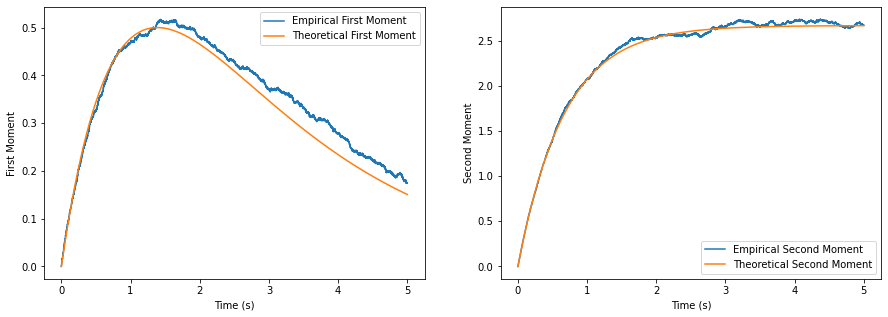

In [12]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(t, EmpiricalFirstMoment_, label="Empirical First Moment")
ax[0].plot(t, TheoreticalFirstMoment_, label="Theoretical First Moment")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("First Moment")
ax[0].legend()

ax[1].plot(t, EmpiricalSecondMoment_, label="Empirical Second Moment")
ax[1].plot(t, TheoreticalSecondMoment_, label="Theoretical Second Moment")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Second Moment")
ax[1].legend();

As we can see, at 10k particles the simulation agrees with the theoretical results.
But how does the number of particles affect the simulation? Let's check it out.
First, we define the error as the mean absolute difference between the theoretical and simulated results.
Then, we measure the behavior of the error as a function of the number of particles.

In [13]:
def ComputeError(simulation, theory):
    return np.mean(np.abs(simulation - theory) / (theory+1e-10))

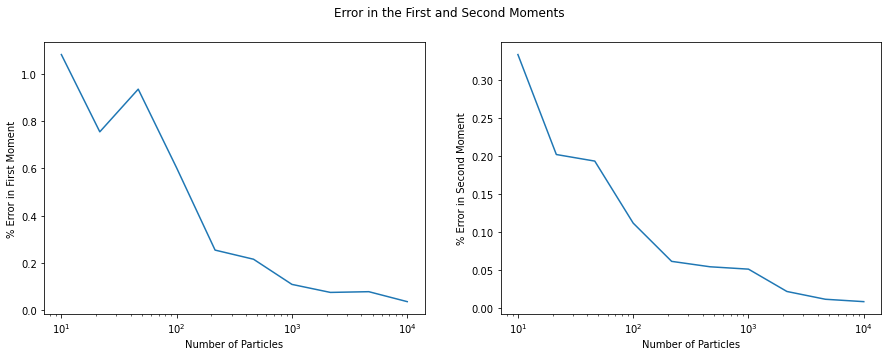

In [14]:
n_particles_space = np.logspace(1,4, num=10)
error_first_moment_trace = np.zeros((len(n_particles_space),))
error_second_moment_trace = np.zeros((len(n_particles_space),))
for n_particles in n_particles_space:
    x_trace = RunTumble(ModelParameter, np.int64(np.floor(n_particles)), dt, TotalTime)[0] # Run the model
    EmpiricalFirstMoment_ = EmpiricalFirstMoment(x_trace)
    EmpiricalSecondMoment_ = EmpiricalSecondMoment(x_trace)
    error_first_moment = ComputeError(EmpiricalFirstMoment_, TheoreticalFirstMoment_)
    error_second_moment = ComputeError(EmpiricalSecondMoment_, TheoreticalSecondMoment_)
    error_first_moment_trace[np.where(n_particles_space == n_particles)] = error_first_moment
    error_second_moment_trace[np.where(n_particles_space == n_particles)] = error_second_moment

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Error in the First and Second Moments")
ax[0].plot(n_particles_space, error_first_moment_trace)
ax[0].set_xscale("log")
ax[0].set_xlabel("Number of Particles")
ax[0].set_ylabel("% Error in First Moment")

ax[1].plot(n_particles_space, error_second_moment_trace)
ax[1].set_xscale("log")
ax[1].set_xlabel("Number of Particles")
ax[1].set_ylabel("% Error in Second Moment");


We can see that to achieve an error less than 5% on the second moment prediction, we need at least 1k particles. 
To achieve an error less than 5% on the first moment prediction, we need at least 5k particles.

This is a highly stochastic model, and the number of particles is crucial to achieve good results. This is and indication that to "distill" information out of the intrinsic stochasticity of the model, we need a large number of samples.


## Entropy Production

Compute the entropy production using the empirical formula through the work.

In [7]:
def ComputeEmpiricalEntropy(x_trace, params, n_sim, dt):
    '''
    Compute the entropy production for the given traces and parameters
    
    INPUT 
    x_trace: array of shape (n_sim, sampled_point_amount) with the x traces
    params: array of shape (2, n_sim) with the parameters

    OUTPUT
    S_mean: mean entropy production
    S_tot: array of shape (n_sim) with the entropy production for each simulation
    '''

    Fx = []
    S_tot = []

    for i in range (n_sim):
        # Unpack Parameters
        k = params[0, i]
        D = params[1, i]

        x = x_trace[i]

        # Compute the force
        F_x =  k * x 
        F_xs = (F_x[1:] + F_x[:-1])/ (2*dt)
        Fx.append(F_xs)

        # Compute the entropy production
        S_x = mean(abs((x[1:] - x[:-1]) * F_xs))
        S_tot.append(S_x)
    
    S_mean = mean(S_tot)
    return S_mean, array(S_tot)

In [8]:
n_sim = 10000
prior_limits = {"k": [10, 20], "omega": [0, 2], "alpha": [0, 1]}
dt = 1e-2
TotalT = 20

k_param = np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], n_sim)
omega_param = np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], n_sim)
alpha_param = np.random.uniform(prior_limits["alpha"][0], prior_limits["alpha"][1], n_sim)


params = np.array([k_param, omega_param, alpha_param])   

In [9]:
x_trace, _ = RunTumble(params, n_sim, dt=dt, TotalT=TotalT)
meanEmpEntr, empEntr = ComputeEmpiricalEntropy(x_trace, params, n_sim, dt)

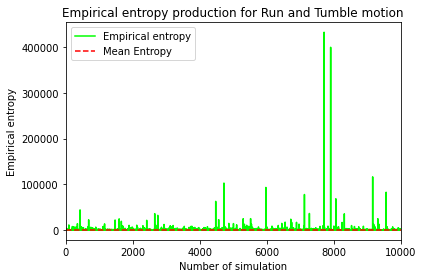

In [10]:
plt.plot(empEntr, c="lime", label="Empirical entropy")
plt.xlim(0, n_sim)
plt.axhline(y=meanEmpEntr, color='r', linestyle='--', label='Mean Entropy')  # Draw a horizontal line at meanEmpEntr
plt.xlabel("Number of simulation")
plt.ylabel("Empirical entropy")
plt.title("Empirical entropy production for Run and Tumble motion")
plt.legend()

In [11]:
print("The mean empirical entropy between simulation is", round(meanEmpEntr, 3))

The mean empirical entropy between simulation is 462.662


## Implementing SBI

In [70]:
# SBI Helper Function
def GenerateDataForSBI(n_sim, prior_limits, dt = 0.01, TotalTime = 1, constant_k = None, constant_omega = None, constant_alpha = None, method = "RAW"):
    t = np.arange(0, TotalTime, dt)
    # Generate the parameters
    if constant_k != None:
        k_param = np.repeat(constant_k, n_sim)
    else:
        k_param = np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], n_sim)
    
    if constant_omega != None:
        omega_param = np.repeat(constant_omega, n_sim)
    else:
        omega_param = np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], n_sim)
        
    if constant_alpha != None:
        alpha_param = np.repeat(constant_alpha, n_sim)
    else:
        alpha_param = np.random.uniform(prior_limits["alpha"][0], prior_limits["alpha"][1], n_sim)
    
    params = np.array([k_param, omega_param, alpha_param])    
    # Simulate the data
    trace = RunTumble(params, n_sim, dt, TotalTime)[0]
    # Save the trace and the parameters in the correct format
    trace = torch.tensor(np.array(trace)).float()
    params = torch.tensor(np.array(params)).float()
    
    prior = utils.BoxUniform(low=torch.tensor([prior_limits["k"][0], prior_limits["omega"][0],prior_limits["alpha"][0]]), high=torch.tensor([prior_limits["k"][1], prior_limits["omega"][1],prior_limits["alpha"][1]]))
    prior, _, _ = process_prior(prior)
    
    SummaryStat = ApplySummaryStatistics(trace.numpy(), method = method, t = t, dt = dt)
    SummaryStat = torch.tensor(SummaryStat).float()
    
    return SummaryStat, params.T, prior

def GenerateDataForSBI_with_proposal(n_sim, proposal, dt = 0.01, TotalT = 1, method = "RAW"):
    t = np.arange(0, TotalT, dt)
 
    params = proposal.sample((n_sim,))
    
    # Simulate the data
    trace = RunTumble(params.numpy().T, n_sim, dt, TotalT)[0]
    
    
    # Save the trace and the parameters in the correct format
    trace = torch.tensor(np.array(trace)).float()
    
    # Apply Summary Statistics
    SummaryStat = ApplySummaryStatistics(trace.numpy(), method = method, t = t, dt = dt)
    SummaryStat = torch.tensor(SummaryStat).float()
    
    return SummaryStat, params, proposal

def LimitsForPlot(prior_limits):
    limits = []
    for key in prior_limits.keys():
        limits.append(prior_limits[key])
    return limits

def GetCentroid(samples):
    centroids = samples.mean(axis=0)
    centroid_spread = samples.std(axis=0)
    
    return centroids, centroid_spread

def PlotSBIResults(samples, theta_test, prior_limits, centroids, centroid_spread, labels=[r"$k$", r"$\omega$", r"$\alpha$"], **kwargs):
    fig, axes = analysis.pairplot(samples, points=theta_test, limits=LimitsForPlot(prior_limits), figsize=(5, 3), labels=[r"$k$", r"$\omega$", r"$\alpha$"], **kwargs)
    
    textstr1 = '\n'.join((
        r'$k_{SBI}=%.2f \pm %.2f$' % (centroids[0], centroid_spread[0]),
        r'$\omega_{SBI}=%.2f\pm %.2f$' % (centroids[1], centroid_spread[1]),
        r'$\alpha_{SBI}=%.2f\pm %.2f$' % (centroids[2], centroid_spread[2])))
    
    textstr2 = '\n'.join((
        r'$k_{True}=%.2f$' % theta_test[0][0],
        r'$\omega_{True}=%.2f$' % theta_test[0][1],
        r'$\alpha_{True}=%.2f$' % theta_test[0][2]))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axes[2,1].text(-0.2, 0.1, textstr1, transform=axes[2,1].transAxes, fontsize=12,
            verticalalignment='top', bbox=props);
    
    axes[2,0].text(-0.1, 1, textstr2, transform=axes[2,0].transAxes, fontsize=12,
            verticalalignment='top', bbox=props);
    
    return centroids, centroid_spread

def CompleteSBIPipeline(n_sim, prior_limits, dt, TotalTime, method = "RAW", rounds = 1, constant_k = None, constant_omega = None, constant_alpha = None, plot = True, TotalTestTime = None):
    if TotalTestTime is None:
        TotalTestTime = TotalTime
    t = np.arange(0, TotalTime, dt)
    x_test, theta_test, prior = GenerateDataForSBI(1, prior_limits, dt, TotalTestTime, method = method, constant_k = constant_k, constant_omega = constant_omega, constant_alpha = constant_alpha)
    inference = SNPE(prior=prior)
    proposal = prior
    
    for _ in np.arange(rounds):
        x, theta, proposal = GenerateDataForSBI_with_proposal(n_sim, proposal, dt, TotalTime, method = method)
        density_estimator = inference.append_simulations(theta, x, proposal = proposal).train(show_train_summary=False)
        posterior = inference.build_posterior(density_estimator)
        print(f"\r Round {_} completed", end = "")
        proposal = posterior.set_default_x(x_test)
    
    
    samples = posterior.sample((100000,), x=x_test.reshape(1, x_test.shape[1]), show_progress_bars=False)
    centroids, centroid_spread = GetCentroid(samples)
    if plot:
        PlotSBIResults(samples, theta_test, prior_limits, centroids, centroid_spread)
    prior_ranges = np.array([prior_limits["k"][1] - prior_limits["k"][0], prior_limits["omega"][1] - prior_limits["omega"][0], prior_limits["alpha"][1] - prior_limits["alpha"][0]])
    compat = np.abs((centroids - theta_test) / prior_ranges) # Cambiare con i limiti della prior
    
    return centroids, centroid_spread, theta_test, compat
    
def TwoPointCorrelationFunction(k, alpha, omega, t, t1):
    D = omega*omega / alpha
    A1 = np.exp(-k * (t - t1))
    B1 = (D / k) * (1 - np.exp(-2 * k * t1)) 
    B2 = 2*omega**2 * (np.exp(-2*k*t1) * 1/(2*k**(k-alpha)) + np.exp(-(k+alpha)*t1)*1/((k+alpha)*(alpha-k)) + 1/(2*k*(k+alpha)))
    A2 = omega/(k + alpha) * (1- np.exp(-(k+alpha)*(t-t1)))
    B3 = omega/(k + alpha) * (1 - np.exp(-(k+alpha)*t1))
    return -A1 * (B1 + B2) - A2 * B3

def ApplySummaryStatistics(trace, method, dt, t = None):    
    if method == "RAW":
        return trace
    elif method == "correlation":
        return np.array([stat_corr_single(trace[i], dt) for i in range(trace.shape[0])])
    elif method == "correlation_fit":
        if t is None:
            raise ValueError("t must be provided")
        def Autocorrelation(t, A, B):
            return A * np.exp(-B*t)
        
        c = ApplySummaryStatistics(trace, dt = dt, method = "correlation")
        params = np.zeros((c.shape[0], 2))
        idx = np.logspace(0, np.log10(c.shape[1]/50), 20).astype(int)
        
        for i in range(c.shape[0]):
            popt, pcov = curve_fit(Autocorrelation, t[idx], c[i,idx], p0 = [1, 1])
            params[i] = popt
        
        return params
        
    else:
        raise ValueError("Method not recognized")
    
def EvaluateSBI(n_runs = 10, SBI_params = {}, plot = True):
    distances = np.zeros((n_runs, 3))
    centroidss = np.zeros((n_runs, 3))
    centroid_spreads = np.zeros((n_runs, 3))
    theta_tests = np.zeros((n_runs, 3))
    
    for i in np.arange(n_runs):
        print(f"\rRun {i+1}/{n_runs}                         ", end = "")
        with io.capture_output() as captured:
            centroids, centroid_spread, theta_test, compat = CompleteSBIPipeline(**SBI_params)
        print("\r                                                                   \r",end="")
        centroidss[i] = centroids
        centroid_spreads[i] = centroid_spread
        theta_tests[i] = theta_test
        distances[i] = centroids - theta_test
    
    if plot:
        SBIEvaluationPlot(centroidss, theta_tests, centroid_spreads)

    return distances, centroidss, centroid_spreads, theta_tests

def SBIEvaluationPlot(centroidss, theta_tests, centroid_spreads):
    fig, axes = plt.subplots(1,3,figsize=(20,5))
    axes[0].errorbar(theta_tests[:,0], centroidss[:,0], yerr=centroid_spreads[:,0], xerr=0, fmt='o', color='blue', alpha = 0.5)
    axes[0].plot([10,20], [10,20], color = "black", linestyle = "--", alpha = 0.2)
    axes[0].set_title(r"Parameter $k$")
    axes[0].set_xlabel("Real Parameter")
    axes[0].set_ylabel("Estimated Parameter")
    
    axes[1].errorbar(theta_tests[:,1], centroidss[:,1], yerr=centroid_spreads[:,1], xerr=0, fmt='o', color='blue', alpha = 0.5)
    axes[1].plot([0,2], [0,2], color = "black", linestyle = "--", alpha = 0.2)
    axes[1].set_title(r"Parameter $\omega$")
    axes[1].set_xlabel("Real Parameter")
    axes[1].set_ylabel("Estimated Parameter")
    
        
    axes[2].errorbar(theta_tests[:,2], centroidss[:,2], yerr=centroid_spreads[:,2], xerr=0, fmt='o', color='blue', alpha = 0.5)
    axes[2].plot([0,2], [0,2], color = "black", linestyle = "--", alpha = 0.2)
    axes[2].set_title(r"Parameter $\alpha$")
    axes[2].set_xlabel("Real Parameter")
    axes[2].set_ylabel("Estimated Parameter")

    fig.suptitle("Estimate vs Real");
    print(f"Average k error: {np.mean(np.abs(centroidss[:,0] - theta_tests[:,0])):.2f}") # If guessing at random, error is 2.5
    print(f"Average D error: {np.mean(np.abs(centroidss[:,1] - theta_tests[:,1])):.2f}") # If guessing at random, error is 0.5
    
def SBI_vs_X(SBI_params,X, n_runs = 10, plot = True):
    """
    X is the name of the parameter to be changed
    """
    distances = np.zeros((SBI_params[X].shape[0], 3))
    stds = np.zeros((SBI_params[X].shape[0], 3))
    
    X_DATA = SBI_params[X]
    
    for i in np.arange(X_DATA.shape[0]):
        print("\rIteration: ", i+1, end = "")
        SBI_params[X] = X_DATA[i]
        with io.capture_output() as captured:
            D, C, CS, TT = EvaluateSBI(n_runs = n_runs, SBI_params = SBI_params, plot=False)
        distances[i] = np.mean(np.abs(D), axis = 0)
        stds[i] = np.std(np.abs(D), axis = 0)
    
    
    if plot:
        fig, ax = plt.subplots(1,3, figsize = (20,5))
        ax[0].errorbar(X_DATA, distances[:,0], yerr = stds[:,0], label = "k", capsize = 5)
        ax[1].errorbar(X_DATA, distances[:,1], yerr = stds[:,1], label = r"$\omega$", capsize = 5)
        ax[2].errorbar(X_DATA, distances[:,2], yerr = stds[:,2], label = r"$\alpha$", capsize = 5)
        ax[0].set_title("Error in k")
        ax[1].set_title(r"Error in $\omega$")
        ax[2].set_title(r"Error in $\alpha$")
        ax[0].set_xlabel(X)
        ax[1].set_xlabel(X)
        ax[2].set_xlabel(X)
        ax[0].set_ylabel("Error")
        ax[1].set_ylabel("Error")
        ax[2].set_ylabel("Error")
    
    return distances, stds

In [34]:
# Define the simulation parameters
n_sim = 5000
prior_limits = {"k": [10, 20], "omega": [0, 2], "alpha": [0, 1]}
dt = 0.01
TotalTime = 50

### SBI: Raw Traces

 Round 0 completed

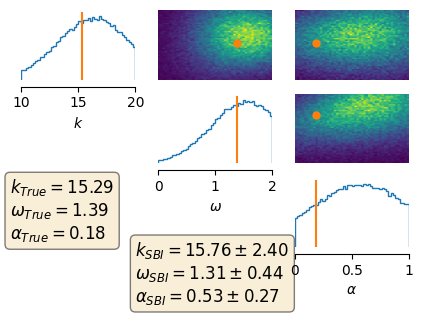

In [18]:
centroids, centroid_spread, theta_test, compat = CompleteSBIPipeline(n_sim, prior_limits, dt, TotalTime, method = "RAW", rounds = 1)

Average k error: 2.14                                              
Average D error: 0.49


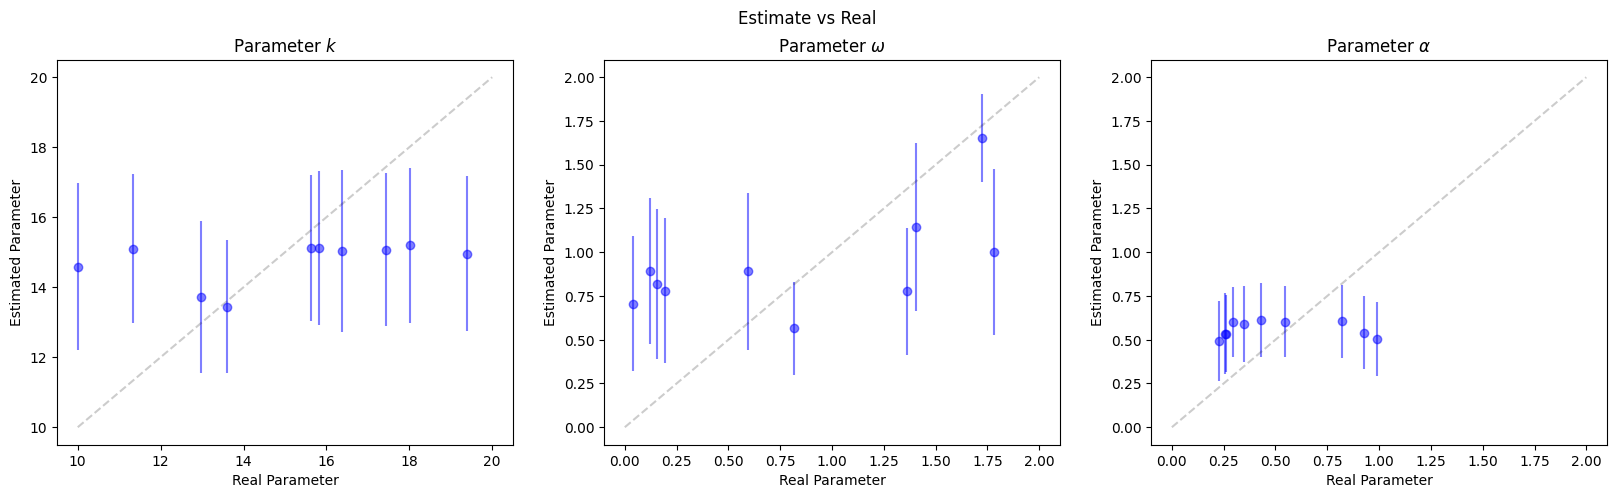

In [6]:
SBI_params = {"n_sim": 5000, "prior_limits": prior_limits, "dt": dt, "TotalTime": TotalTime, "method": "RAW", "rounds": 1, "plot": False}
distances, centroidss, centroid_spreads, theta_tests = EvaluateSBI(n_runs = 10, SBI_params = SBI_params)

### SBI: AutoCorrelation Trace

Average k error: 2.71                                              
Average D error: 0.27


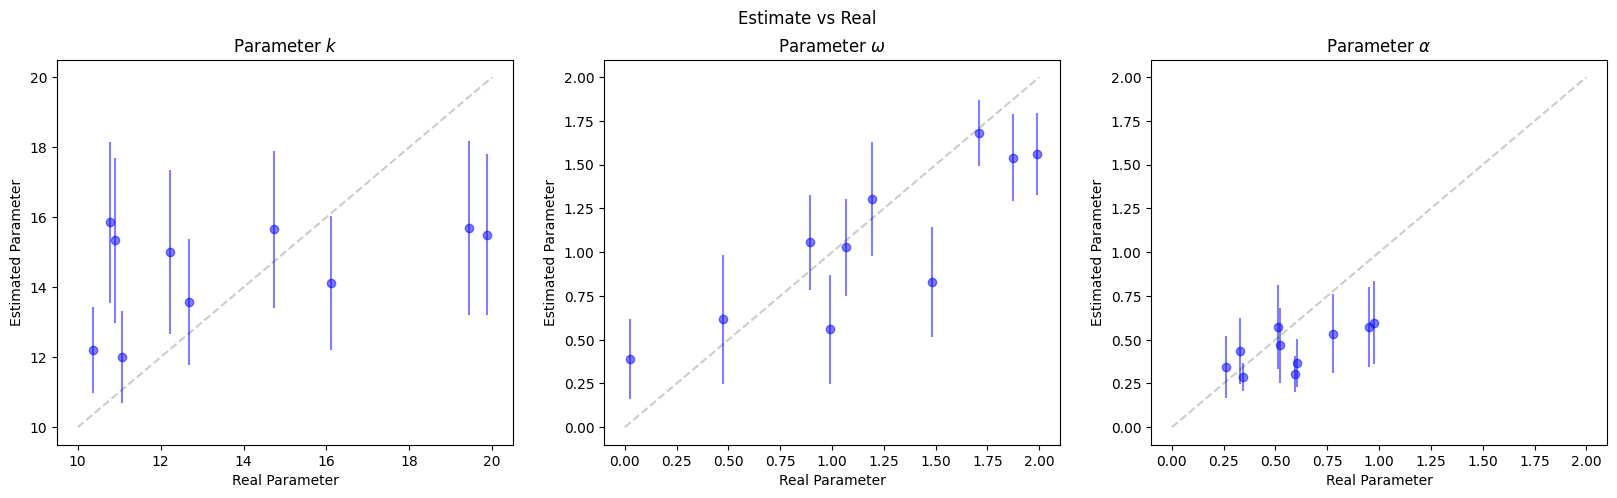

In [7]:
SBI_params = {"n_sim": 5000, "prior_limits": prior_limits, "dt": dt, "TotalTime": TotalTime, "method": "correlation", "rounds": 1, "plot": False}
distances, centroidss, centroid_spreads, theta_tests = EvaluateSBI(n_runs = 10, SBI_params = SBI_params)

### SBI: Correlation Fit

 Round 0 completed

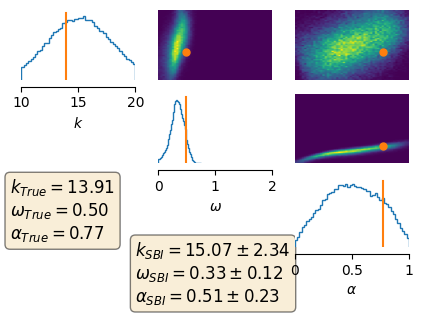

In [14]:
centroids, centroid_spread, theta_test, compat = CompleteSBIPipeline(5000, prior_limits, dt, TotalTime=2, method = "correlation_fit", rounds = 1, plot = True, TotalTestTime = 10)

Average k error: 1.02                                              
Average D error: 0.26


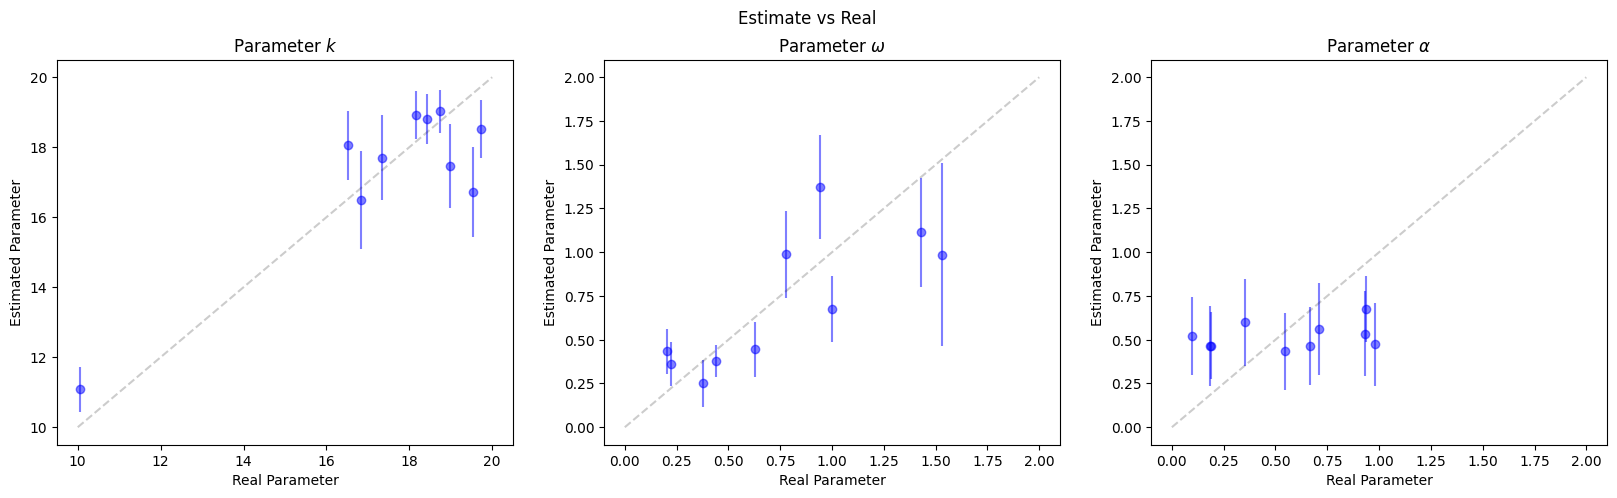

In [15]:
SBI_params = {"n_sim": 5000, "prior_limits": prior_limits, "dt": dt, "TotalTime": 50, "method": "correlation_fit", "rounds": 1, "plot": False}
distances, centroidss, centroid_spreads, theta_tests = EvaluateSBI(n_runs = 10, SBI_params = SBI_params)

Iteration:  8

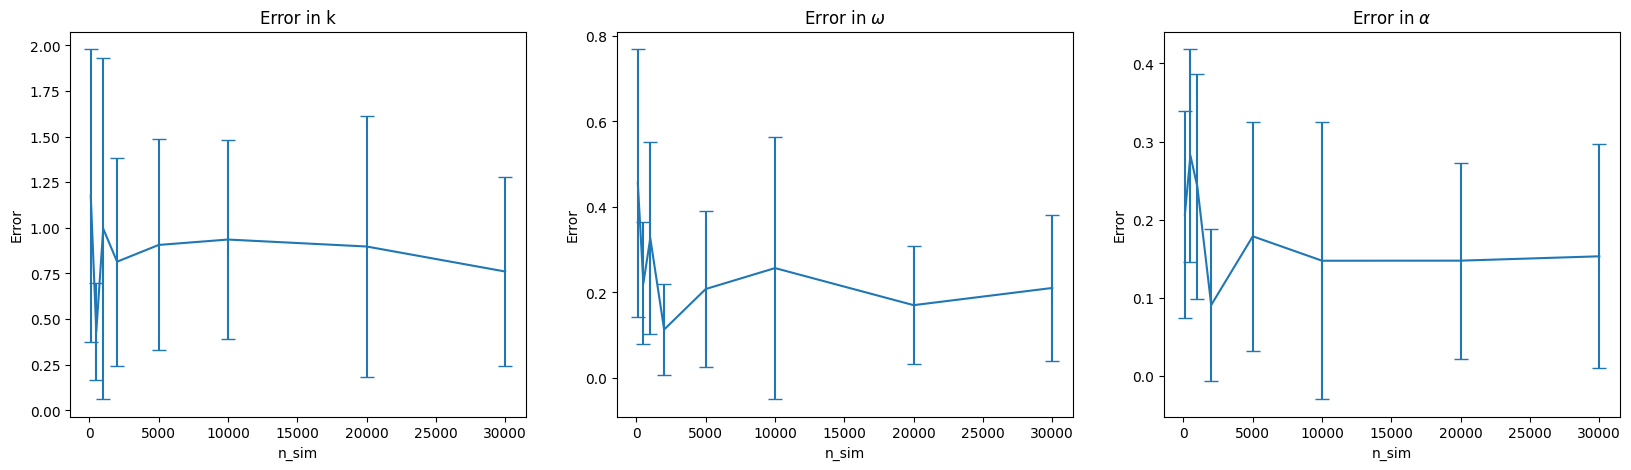

In [16]:
n_sim = np.array([100,500,1000,2000,5000,10000,20000,30000])
SBI_params = {"n_sim": n_sim, "prior_limits": prior_limits, "dt": dt, "TotalTime": 50, "method": "correlation_fit", "rounds": 1, "plot": False}
distances, stds = SBI_vs_X(SBI_params, "n_sim")

Iteration:  10

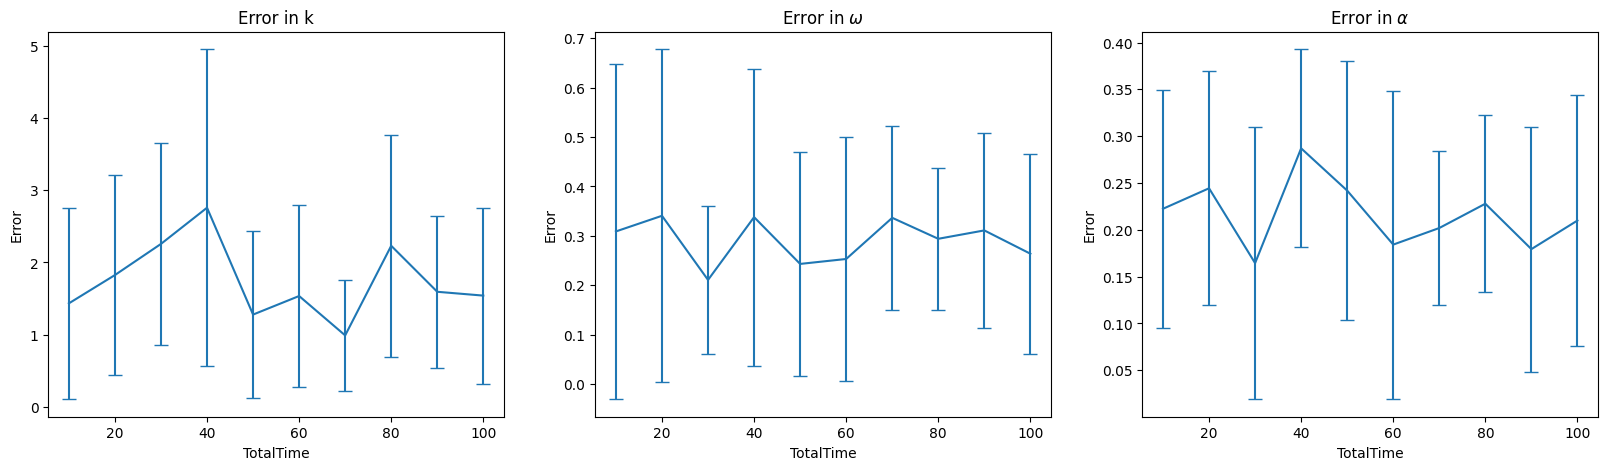

In [71]:
TotalTime = np.array([10,20,30,40,50,60,70,80,90,100])
SBI_params = {"n_sim": 2000, "prior_limits": prior_limits, "dt": dt, "TotalTime": TotalTime, "method": "correlation_fit", "rounds": 1, "plot": False, "TotalTestTime":10}
distances, stds = SBI_vs_X(SBI_params, "TotalTime")